In [42]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
%pip install efficientnet
from efficientnet.tfkeras import EfficientNetB4
from efficientnet.tfkeras import EfficientNetB2
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from enum import Enum

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
num_epochs = 24
#extra_to_majority = 2000
extra_to_majority = 5
fake_data = True


class SelectedModel(Enum):
    Eff0 = (224, 224)  # Example image size for EfficientNet 0
    Eff2 = (260, 260)  # Example image size for EfficientNet 2
    Eff4 = (380, 380)  # Example image size for EfficientNet 4
    ResNet50 = (224, 224)  # Example image size for ResNet50

    @property
    def image_size(self):
        return self.value
    def is_eff_family(self):
      return self in (SelectedModel.Eff0, SelectedModel.Eff2, SelectedModel.Eff4)


# Select the model
my_mod = SelectedModel.ResNet50

In [57]:
from matplotlib.layout_engine import TightLayoutEngine
# Function to display images in a grid
def display_images_in_grid(images, labels, predictions=None, ncols=4):
  print("Num images: "+str(len(images)))
  nrows = (len(images) + ncols -1) // ncols

  plt.figure(figsize=(15, 10))

  for i in range(len(images)):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(cv2.cvtColor(cv2.imread(images[i]), cv2.COLOR_BGR2RGB))  # Read and display the image
    if predictions:
      plt.title(f"True: {labels[i]}\nPredicted: {predictions[i]}")
    else:
      plt.title(f"True: {labels[i]}")
    plt.axis('off')
  plt.tight_layout()
  plt.show()

def predict_and_display_images_in_grid(model, data_gen, num_images_to_display = 16  ):
  #print(data_gen.class_indices)
  class_labels = {value: key for key, value in unfiltered_data_generator.class_indices.items()}
  #class_labels = list(unfiltered_data_generator.class_indices.keys())print(unfiltered_data_generator.class_indices)
  print(class_labels)


  for x,y in data_gen:
    print(type(x))
    print(type(y))
    break
  predictions = model.predict(data_gen)
  sample_size = min(num_images_to_display, len(predictions))
  sample_indices = random.sample(range(len(predictions)), sample_size)
  predicted_labels = [class_labels[i] for i in np.argmax(predictions, axis=1)]
  ground_truth_labels = [class_labels[i] for i in data_gen.classes]
  #Select a subset of test images and labels to display

  image_file_names = data_gen.filenames

  # Display the images and their labels/predictions
  i_to_plot, g_to_plot, p_to_plot = [],[],[]
  for i, idx in enumerate(sample_indices):
    i_to_plot.append(image_file_names[idx])
    g_to_plot.append(ground_truth_labels[idx])
    p_to_plot.append( predicted_labels[idx])
  display_images_in_grid(
      i_to_plot,
      g_to_plot,
      p_to_plot)
  # Calculate accuracy
  accuracy = accuracy_score(ground_truth_labels, predicted_labels)
  print("Accuracy: {:.2%}".format(accuracy))
  ret={}
  ret['accuracy']=accuracy
  ret['groundtruth']=ground_truth_labels
  ret['filenames']=image_file_names
  ret['predictions']=predicted_labels
  return ret
  #f1 = f1_score(ground_truth_labels, predicted_labels)
  #print("F1: {:.2%}".format(accuracy))
  #ret['f1']=f1
  #precision = precision_score(ground_truth_labels, predicted_labels)
  #print("Precision: {:.2%}".format(precision))
  #ret['precision']=precision
  #recall = recall_score(ground_truth_labels, predicted_labels)
  #print("Recall: {:.2%}".format(recall))
  #ret['recall']=recall

def show_confusion_matrix(truth, pred, title):
  print("Showing Confusion Matrix")
  print(len(truth))
  print(len(pred))

  conf_matrix = confusion_matrix(truth, pred)

  # Create a heatmap to visualize the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(title)
  plt.show()


def plot_sample_from_filenames(df):
  # Randomly select 16 indices from your DataFrame
  sample_indices = random.sample(range(len(df)), 16)

  # Create a subplot with 4 rows and 4 columns to display the images
  plt.figure(figsize=(10, 10))
  for i, idx in enumerate(sample_indices):
    image_path = df['filename'].iloc[idx]
    label = df['class'].iloc[idx]

    ax = plt.subplot(4, 4, i + 1)
    img = plt.imread(image_path)

    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

  plt.show()

def plot_class_counts(df, xname):
  # Create a count plot using Seaborn
  plt.figure(figsize=(8, 6))
  sns.set(style='whitegrid')  # Set the style

  # Create the count plot
  sns.countplot(data=df, x=xname)

  # Set plot labels and title
  plt.xlabel(xname)
  plt.ylabel('Count')
  plt.title('Count of Each Class')

  # Show the plot
  plt.show()


# Define a custom function to filter out file paths containing "mask"
def filter_mask_images(image_paths, labels):
    filtered_paths, filtered_labels = [], []
    for path, label in zip(image_paths, labels):
        if "mask" not in os.path.basename(path):  # Check if "mask" is not in the filename
            filtered_paths.append(path)
            filtered_labels.append(label)
    return np.array(filtered_paths), np.array(filtered_labels)

def create_generator(given_df, image_size, batch_size, image_generator, augment=False):
  if augment:
    return image_generator.flow_from_dataframe(
        given_df,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42,
        zoom_range=.2,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=.2,
        height_shift_range=.2,
        fill_mode='nearest')
  return image_generator.flow_from_dataframe(
      given_df,
      target_size=image_size,
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=True,
      seed=42)


In [46]:

# Define the directory where your images are stored
base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT'
if fake_data:
  base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Fake'

# Define your image dimensions and batch size
image_size = my_mod.image_size
batch_size = 32

# Create an ImageDataGenerator for reading and preprocessing the images
# Normalize the intensitities to [0,1]
image_generator = ImageDataGenerator(rescale=1./255)

unfiltered_data_generator = image_generator.flow_from_directory(
    base_directory,
    target_size=image_size,  # Set the target image size
    batch_size=batch_size,
    class_mode='categorical',  # For multiple classes, use 'categorical'
    shuffle=True  # You can set this to False if you want to preserve the order
)

# Load the image file paths and labels
print(unfiltered_data_generator.classes  )



Found 48 images belonging to 3 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2]


In [47]:
class_labels = {value: key for key, value in unfiltered_data_generator.class_indices.items()}
image_paths, labels = filter_mask_images(unfiltered_data_generator.filepaths, [class_labels[i] for i in unfiltered_data_generator.classes])
print("Image path size = "+str(len(image_paths)))

Image path size = 48


Found 38 validated image filenames belonging to 3 classes.
Found 10 validated image filenames belonging to 3 classes.


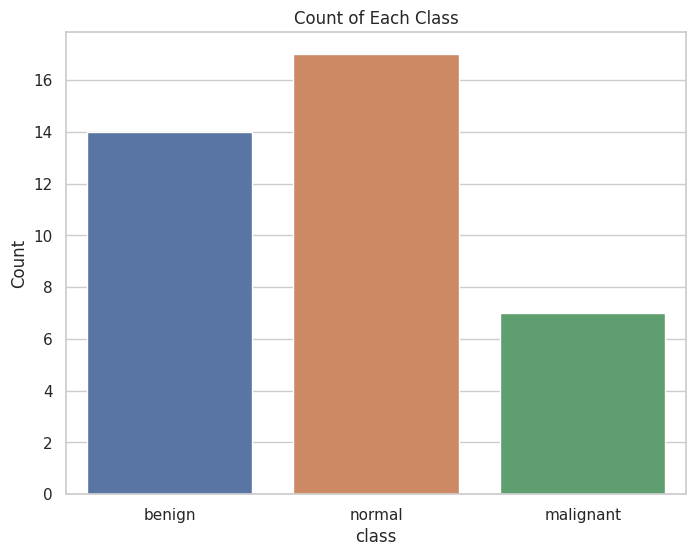

                                                             filename   class
0   ./drive/MyDrive/ML/BreastCancerProject/data/Fake/benign/img12.png  benign
1  ./drive/MyDrive/ML/BreastCancerProject/data/Fake/benign/img110.png  benign
2  ./drive/MyDrive/ML/BreastCancerProject/data/Fake/benign/img113.png  benign
3  ./drive/MyDrive/ML/BreastCancerProject/data/Fake/normal/img219.png  normal
4  ./drive/MyDrive/ML/BreastCancerProject/data/Fake/normal/img213.png  normal


In [48]:

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Create separate data generators for training and testing
train_data_generator = create_generator(
    pd.DataFrame({'filename': train_image_paths, 'class': train_labels}),
    image_size,
    batch_size,
    image_generator)


test_data_generator = create_generator(
    pd.DataFrame({'filename': test_image_paths, 'class': test_labels}),
    image_size,
    batch_size,
    image_generator)

# Convert the class indices to class labels
class_labels = list(train_data_generator.class_indices.keys())

# Create a DataFrame with the image file paths and labels
df = pd.DataFrame({
    'filename': train_data_generator.filepaths,
    'class': [class_labels[i] for i in train_data_generator.classes]
})



pd.set_option('display.max_colwidth', None)
plot_class_counts(df, "class")
# Display the first few rows of the DataFrame
print(df.head())

Found 17 validated image filenames belonging to 1 classes.
Found 7 validated image filenames belonging to 1 classes.
Found 14 validated image filenames belonging to 1 classes.
5
15
8


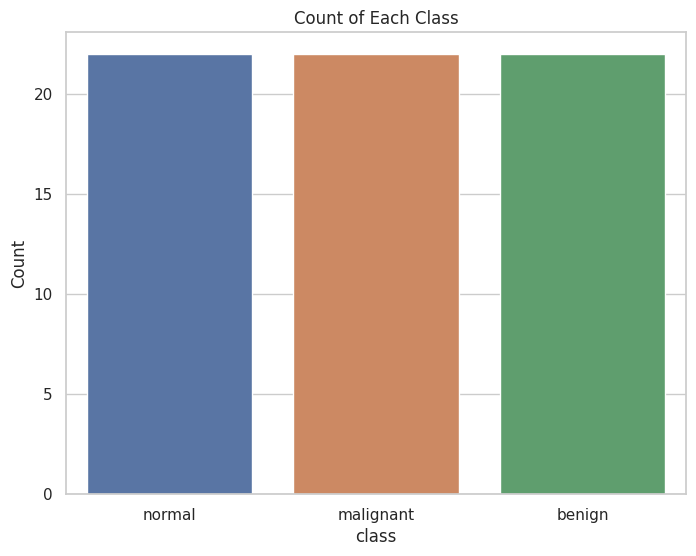

                                                              filename   class
3   ./drive/MyDrive/ML/BreastCancerProject/data/Fake/normal/img219.png  normal
4   ./drive/MyDrive/ML/BreastCancerProject/data/Fake/normal/img213.png  normal
7    ./drive/MyDrive/ML/BreastCancerProject/data/Fake/normal/img27.png  normal
11   ./drive/MyDrive/ML/BreastCancerProject/data/Fake/normal/img21.png  normal
12  ./drive/MyDrive/ML/BreastCancerProject/data/Fake/normal/img212.png  normal


In [49]:
# Create DataFrames for each class
df_normal = df[df['class'] == 'normal']
df_malignant = df[df['class'] == 'malignant']
df_benign = df[df['class'] == 'benign']
# Calculate the number of samples in the majority class
majority_count = max(len(df_normal), len(df_malignant), len(df_benign)) + extra_to_majority



# Oversample 'normal' class
normal_generator = create_generator(
    df_normal,
    image_size,
    majority_count - len(df_normal),
    image_generator,
    True
)

# Oversample 'malignant' class
malignant_generator = create_generator(
    df_malignant,
    image_size,
    majority_count - len(df_malignant),
    image_generator,
    True
)

# Oversample 'benign' class
benign_generator = create_generator(
    df_benign,
    image_size,
    majority_count - len(df_benign),
    image_generator,
    True
)
aa=df_normal.sample(majority_count - len(df_normal), replace=True)
bb=df_malignant.sample(majority_count - len(df_malignant), replace=True)
cc=df_benign.sample(majority_count - len(df_benign), replace=True)
print(len(aa))
print(len(bb))
print(len(cc))

# Concatenate the oversampled dataframes
augmented_data = pd.concat([df_normal, df_malignant, df_benign,
                            aa,bb,cc])

# Now 'augmented_data' contains your balanced dataset with augmented data
df=augmented_data
plot_class_counts(df, "class")
# Display the first few rows of the DataFrame
print(df.head())

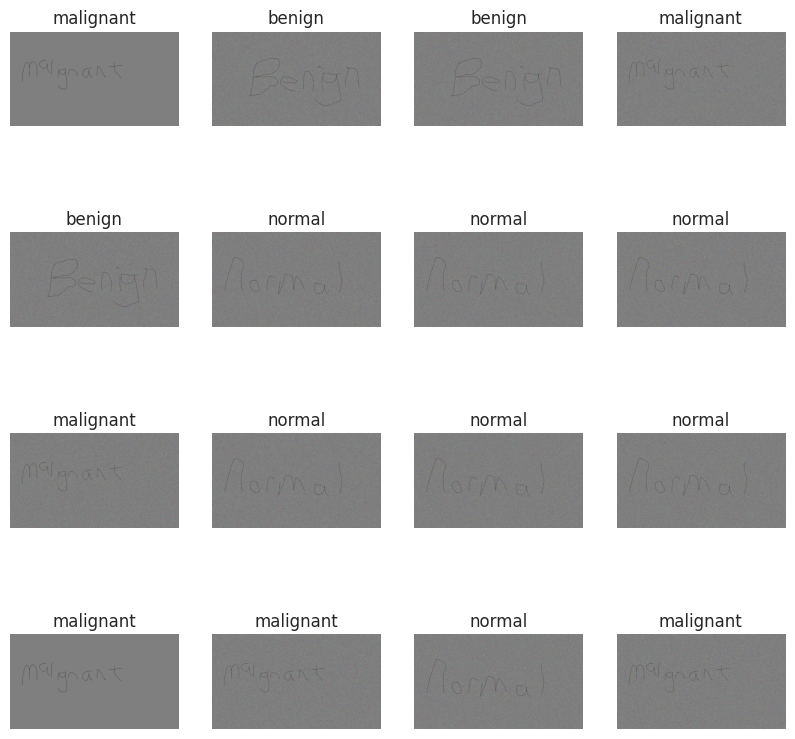

In [50]:


plot_sample_from_filenames(df)


In [51]:
num_classes = 3
base_model = None
if True:
  if my_mod is SelectedModel.Eff0:
    base_model= EfficientNetB0(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))

  elif my_mod is SelectedModel.Eff2:
    base_model= EfficientNetB2(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))

  elif my_mod is SelectedModel.Eff4:
    base_model= EfficientNetB4(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))
  elif my_mod is SelectedModel.ResNet50:
      base_model = ResNet50(
      include_top=False,
      weights='imagenet',
      input_shape=(image_size[0], image_size[1], 3))
  else:
    print("Unexpected model type "+str(my_mod))
    exit()
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.001),  # You can adjust the learning rate
  loss='categorical_crossentropy',
  metrics=['accuracy']
)
model.summary()




Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 112, 112, 32)         0         ['stem_bn[0][0]']       

In [52]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [53]:
#model.fit(
#    train_data_generator,
#    epochs=num_epochs,
#    validation_data=test_data_generator
#)


In [54]:
# Define a learning rate schedule function
def lr_schedule(epoch):

    if epoch < 6:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Define a ModelCheckpoint callback to save the best model during training
model_checkpoint = ModelCheckpoint('best_model'+str(image_size[0])+'.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min', verbose=1)

# Define an EarlyStopping callback to stop training if the validation loss does not improve
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train your model and use the callbacks
history = model.fit(
    train_data_generator,
    epochs=num_epochs,
    validation_data=test_data_generator,
    callbacks=[model_checkpoint, early_stopping, lr_scheduler],
    verbose=1,  # Set verbose to 1 to display training progress,
)


Epoch 1/24
2/2 [==============================] - ETA: 0s - loss: 1.0947 - accuracy: 0.3684 
Epoch 1: val_loss improved from inf to 1.09445, saving model to best_model224.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 43s 15s/step - loss: 1.0947 - accuracy: 0.3684 - val_loss: 1.0944 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 2/24
2/2 [==============================] - ETA: 0s - loss: 0.4206 - accuracy: 0.9211
Epoch 2: val_loss did not improve from 1.09445
2/2 [==============================] - 13s 10s/step - loss: 0.4206 - accuracy: 0.9211 - val_loss: 1.1430 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 3/24
2/2 [==============================] - ETA: 0s - loss: 0.1735 - accuracy: 0.9737
Epoch 3: val_loss did not improve from 1.09445
2/2 [==============================] - 12s 10s/step - loss: 0.1735 - accuracy: 0.9737 - val_loss: 1.1843 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 4/24
2/2 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.9474 
Epoch 4: val_loss did not improve from 1.09445
Restoring model weights from the end of the best epoch: 1.
2/2 [==============================] - 13s 3s/step - loss: 0.2157 - accuracy: 0.9474 - val_loss: 1.2

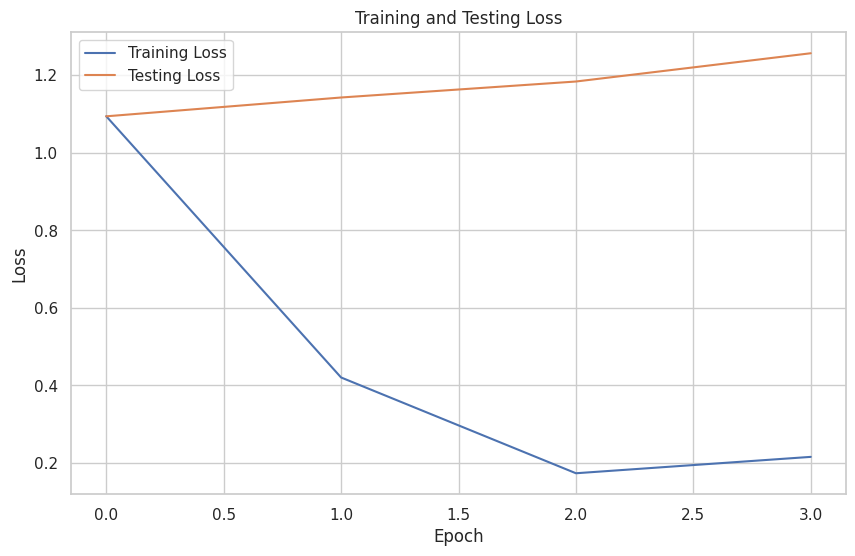

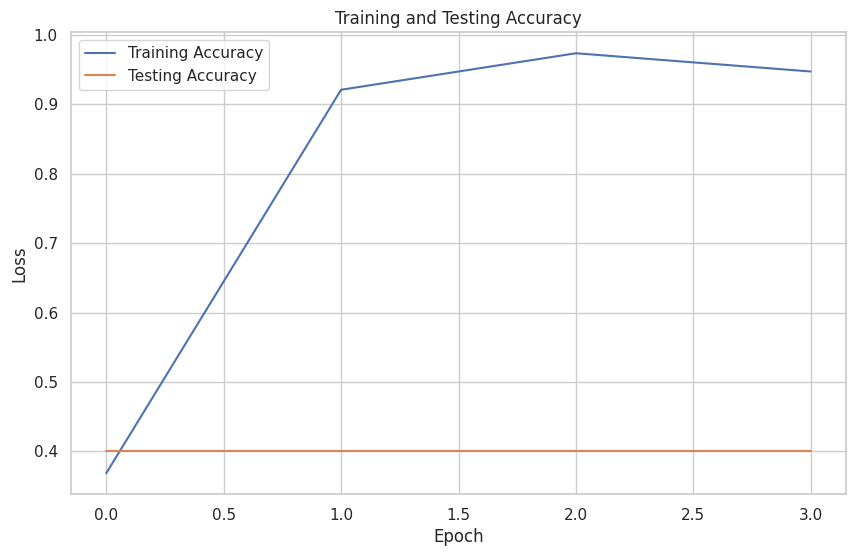

In [55]:


# Assuming you've trained your model and have the `history` object
# The `history` object typically contains 'loss' and 'val_loss' values

# Plot training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
# Plot training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [56]:
results=predict_and_display_images_in_grid(model, test_data_generator)
ground_truth_labels=results['groundtruth']
predicted_labels=results['predictions']
print(len(ground_truth_labels))
print(len(predicted_labels))

{0: 'benign', 1: 'malignant', 2: 'normal'}


AttributeError: ignored

In [ ]:
results_training=predict_and_display_images_in_grid(model, train_data_generator);
ground_truth_labels_training=results_training['groundtruth']
predicted_labels_training=results_training['predictions']

print(len(ground_truth_labels_training))
print(len(predicted_labels_training))

In [ ]:

show_confusion_matrix(ground_truth_labels, predicted_labels, "Confusion Matrix (Test Data)")
show_confusion_matrix(ground_truth_labels_training, predicted_labels_training, "Confusion Matrix (Training Data)")